In [1]:
!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo
chronic_kidney_disease = fetch_ucirepo(id=336)

X = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

print(chronic_kidney_disease.metadata)

print(chronic_kidney_disease.variables)

{'uci_id': 336, 'name': 'Chronic Kidney Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/336/data.csv', 'abstract': 'This dataset can be used to predict the chronic kidney disease and it can be collected from the hospital nearly 2 months of period.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 400, 'num_features': 24, 'feature_types': ['Real'], 'demographics': ['Age'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5G020', 'creators': ['L. Rubini', 'P. Soundarapandian', 'P. Eswaran'], 'intro_paper': None, 'additional_info': {'summary': 'We use the following representation to collect the dataset\r\n                        age\t\t-\tage\t\r\n\t\t\tbp\t\t-\tblood pressure\r\n\t\t\tsg\t

In [3]:
len(chronic_kidney_disease.data.targets)
len(chronic_kidney_disease.data.features)

400

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook
import random
import math
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.concat([X,y], axis=1)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


##Data Preprocessing

In [5]:
df.isna().sum()

,0
age,9
bp,12
sg,47
al,46
su,49
rbc,152
pc,65
pcc,4
ba,4
bgr,44


In [6]:
numerical_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba']
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

binary_cols = ['htn', 'dm', 'cad', 'appet', 'pe', 'ane']
df[binary_cols] = df[binary_cols].fillna(df[binary_cols].mode().iloc[0])

df.isna().sum()

,0
age,0
bp,0
sg,0
al,0
su,0
rbc,0
pc,0
pcc,0
ba,0
bgr,0


In [7]:
df[categorical_cols] = df[categorical_cols].astype('category')
df[categorical_cols] = df[categorical_cols].apply(lambda col: col.cat.codes)

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,3,1,0,1,1,0,0,121.000000,...,44.0,7800.0,5.200000,yes,yes,no,good,no,no,ckd
1,7.0,50.0,3,4,0,1,1,0,0,148.036517,...,38.0,6000.0,4.707435,no,no,no,good,no,no,ckd
2,62.0,80.0,1,2,3,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,0,4,0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1,2,0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,no,no,no,good,no,no,ckd


In [8]:
df[binary_cols] = df[binary_cols].astype('category')
df[binary_cols] = df[binary_cols].apply(lambda col: col.cat.codes)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,3,1,0,1,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,2,0,0,0,0,ckd
1,7.0,50.0,3,4,0,1,1,0,0,148.036517,...,38.0,6000.0,4.707435,0,1,0,0,0,0,ckd
2,62.0,80.0,1,2,3,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,0,2,0,1,0,1,ckd
3,48.0,70.0,0,4,0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,1,0,1,1,1,ckd
4,51.0,80.0,1,2,0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,1,0,0,0,0,ckd


In [9]:
df["class"] = df["class"].map({"ckd": 1, "notckd": 0})
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,3,1,0,1,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,2,0,0,0,0,1.0
1,7.0,50.0,3,4,0,1,1,0,0,148.036517,...,38.0,6000.0,4.707435,0,1,0,0,0,0,1.0
2,62.0,80.0,1,2,3,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,0,2,0,1,0,1,1.0
3,48.0,70.0,0,4,0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,1,0,1,1,1,1.0
4,51.0,80.0,1,2,0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,1,0,0,0,0,1.0


In [10]:
df["class"].fillna(1, inplace=True)
print(df["class"].unique())


[1. 0.]


<ipython-input-10-296bb21e62de>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["class"].fillna(1, inplace=True)


In [18]:
X_train = df.drop('class', axis=1).values
y_train = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [19]:
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))

In [20]:
X_train.shape

torch.Size([320, 24])

In [21]:
y_train.shape

torch.Size([320])

In [22]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

<ipython-input-22-5445d9a3b550>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-22-5445d9a3b550>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-22-5445d9a3b550>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
<ipython-input-22-5445d9a3b550>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

In [15]:
class network(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
        super(network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      return x

In [23]:
input_size = X_train_tensor.shape[1]
hidden_size = 16
output_size = 2
learning_rate = 0.01
num_epochs = 1000

In [ ]:
model = network(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/1000], Loss: 0.0312
Epoch [20/1000], Loss: 0.0307
Epoch [30/1000], Loss: 0.0302
Epoch [40/1000], Loss: 0.0297
Epoch [50/1000], Loss: 0.0292
Epoch [60/1000], Loss: 0.0287
Epoch [70/1000], Loss: 0.0283
Epoch [80/1000], Loss: 0.0278
Epoch [90/1000], Loss: 0.0274
Epoch [100/1000], Loss: 0.0269
Epoch [110/1000], Loss: 0.0265
Epoch [120/1000], Loss: 0.0261
Epoch [130/1000], Loss: 0.0257
Epoch [140/1000], Loss: 0.0253
Epoch [150/1000], Loss: 0.0249
Epoch [160/1000], Loss: 0.0245
Epoch [170/1000], Loss: 0.0241
Epoch [180/1000], Loss: 0.0237
Epoch [190/1000], Loss: 0.0233
Epoch [200/1000], Loss: 0.0230
Epoch [210/1000], Loss: 0.0226
Epoch [220/1000], Loss: 0.0223
Epoch [230/1000], Loss: 0.0219
Epoch [240/1000], Loss: 0.0216
Epoch [250/1000], Loss: 0.0213
Epoch [260/1000], Loss: 0.0209
Epoch [270/1000], Loss: 0.0206
Epoch [280/1000], Loss: 0.0203
Epoch [290/1000], Loss: 0.0200
Epoch [300/1000], Loss: 0.0197
Epoch [310/1000], Loss: 0.0194
Epoch [320/1000], Loss: 0.0191
Epoch [330/1000],

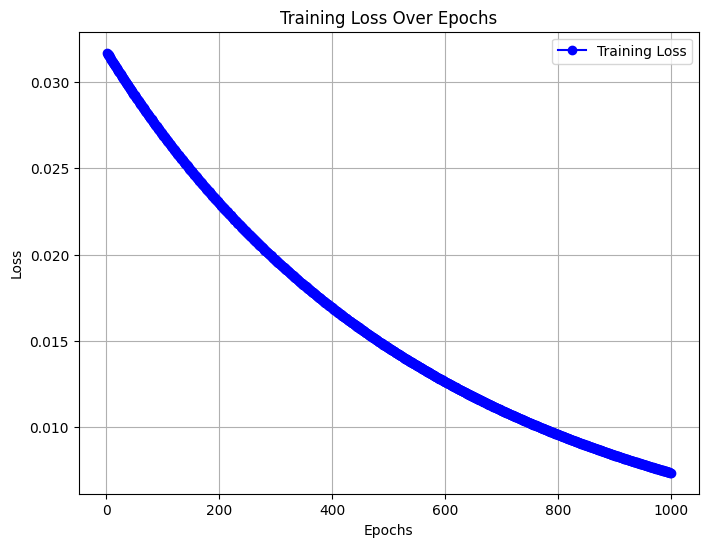

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss', color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes.numpy(), target_names=["notckd", "ckd"]))


Classification Report:
              precision    recall  f1-score   support

      notckd       0.93      0.96      0.95        27
         ckd       0.98      0.96      0.97        53

    accuracy                           0.96        80
   macro avg       0.95      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



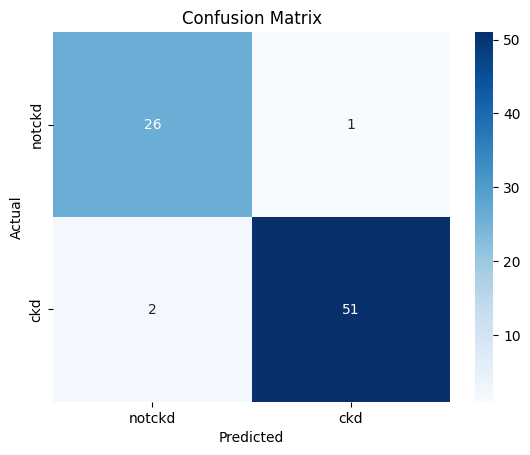

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_classes.numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["notckd", "ckd"], yticklabels=["notckd", "ckd"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [11]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(df.drop('class', axis=1).values)

In [12]:
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(
    X_standardized, df['class'].values, test_size=0.2
)

In [13]:
X_train_tensor_std = torch.tensor(X_train_std, dtype=torch.float32)
X_test_tensor_std = torch.tensor(X_test_std, dtype=torch.float32)
y_train_tensor_std = torch.tensor(y_train_std, dtype=torch.long)
y_test_tensor_std = torch.tensor(y_test_std, dtype=torch.long)

In [24]:
model_std = network(input_size, hidden_size, output_size)
criterion_std = nn.CrossEntropyLoss()
optimizer_std = optim.Adam(model_std.parameters(), lr=learning_rate)

In [25]:
losses_std = []

for epoch in range(num_epochs):
    model_std.train()
    optimizer_std.zero_grad()
    outputs_std = model_std(X_train_tensor_std)
    loss_std = criterion_std(outputs_std, y_train_tensor_std)
    loss_std.backward()
    optimizer_std.step()

    losses_std.append(loss_std.item())

    if (epoch + 1) % 100 == 0:
        print(f"[Standardized Data] Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_std.item():.4f}")


[Standardized Data] Epoch [100/1000], Loss: 0.0053
[Standardized Data] Epoch [200/1000], Loss: 0.0017
[Standardized Data] Epoch [300/1000], Loss: 0.0009
[Standardized Data] Epoch [400/1000], Loss: 0.0005
[Standardized Data] Epoch [500/1000], Loss: 0.0003
[Standardized Data] Epoch [600/1000], Loss: 0.0002
[Standardized Data] Epoch [700/1000], Loss: 0.0002
[Standardized Data] Epoch [800/1000], Loss: 0.0001
[Standardized Data] Epoch [900/1000], Loss: 0.0001
[Standardized Data] Epoch [1000/1000], Loss: 0.0001


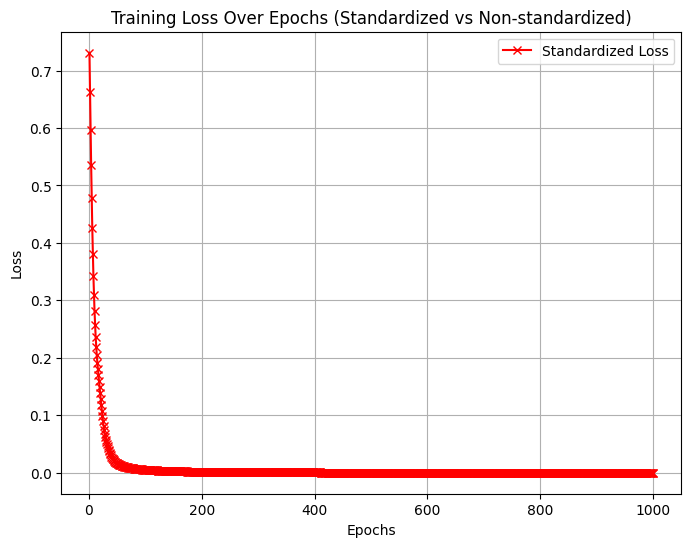

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), losses_std, label='Standardized Loss', color='red', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (Standardized vs Non-standardized)')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
model_std.eval()
with torch.no_grad():
    y_pred_std = model_std(X_test_tensor_std)
    y_pred_classes_std = torch.argmax(y_pred_std, axis=1)

print("\n[Standardized Data] Classification Report:")
print(classification_report(y_test_std, y_pred_classes_std.numpy(), target_names=["notckd", "ckd"]))


[Standardized Data] Classification Report:
              precision    recall  f1-score   support

      notckd       0.94      1.00      0.97        33
         ckd       1.00      0.96      0.98        47

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



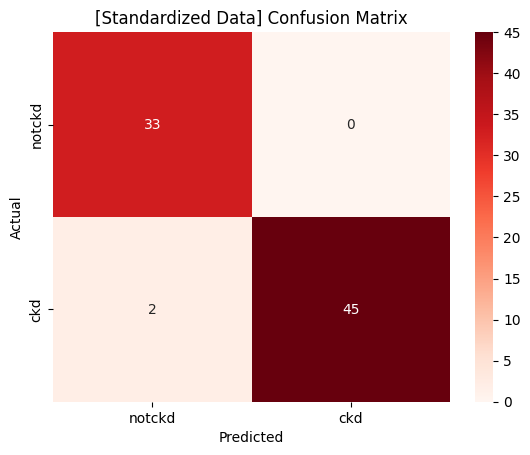

In [31]:
conf_matrix_std = confusion_matrix(y_test_std, y_pred_classes_std.numpy())
sns.heatmap(conf_matrix_std, annot=True, fmt='d', cmap='Reds', xticklabels=["notckd", "ckd"], yticklabels=["notckd", "ckd"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("[Standardized Data] Confusion Matrix")
plt.show()